# Zappa paints Zappa
<p class="lead">
Teaching a Deep Neural Network to paint album covers
</p>

Frank Zappa was an extremely prolific musician with over 100 studio albums recorded during his lifetime. He also was a big fan of using new technology to compose music which may have been too difficult for humans to perform. In addition to his unique musical vision, he also had some fascinating and iconographic album covers created by artists such as Cal Schenkel and Neon Parks, which set his albums apart visually from others in record store bins.

In the sections below, I will attempt to train a deep neural network to "paint" Zappa album covers using Tensorflow, by following a method described by Andrej Karpathy in his online demonstration of "image inpainting". We will train our networks with images of album covers and see what happens.

In [22]:
# Get all imports
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from libs import utils, gif, images
import IPython.display as ipyd

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

## Loading the image dataset

Let's load 100 images of various Frank Zappa album covers. We will crop/resize each image to make sure they are the same size and shape (100px squares) and then we will save a montage of all covers together and display it in the notebook.

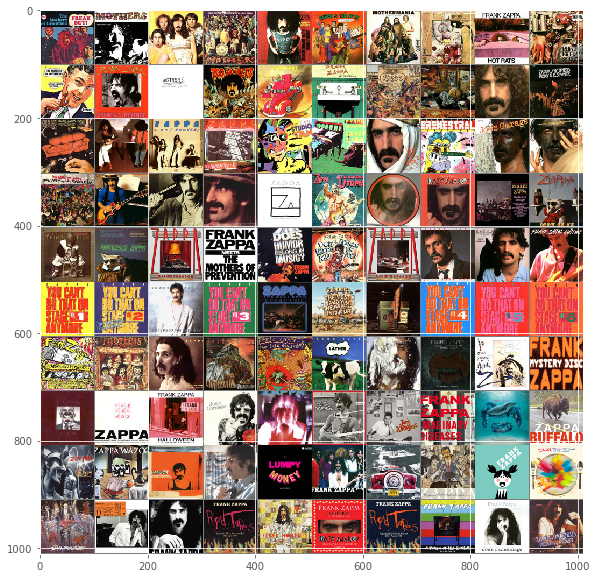

In [2]:
imgs = images.get_album_covers()
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(imgs, saveto='imgs/zappa.png'))

## Feature Detection

Next, we will need to create a way to detect some features found in the album covers. This will be done using a Gabor filter which welp help us find horizontal edges at a specific scale. This will respond equally to all color channels in each image (red, green, blue).

To detect the edges we will need to first convolve our dataset using the same filter on each image.

### Convolving the dataset

In order to convolve our images, we will need to normalize the dataset using the images mean and std deviation.

First we'll need to find the mean image of the dataset as a 4-D array.

In [3]:
# Create a tensorflow session
sess = tf.Session()

# First compute the difference of every image with a
# 4 dimensional mean image shaped 1 x H x W x C
mean_img_4d = tf.reduce_mean(imgs, axis=0, keep_dims=True)

Now in `mean_img_4d`, for every pixel in our dataset, we have a mean of possible values it could have had for each image. This will allow us to compute the square root of the expected squared difference for our standard deviation.

In [4]:
expected_difference = imgs - mean_img_4d

std_deviation = tf.sqrt(
    tf.reduce_sum(expected_difference * expected_difference, reduction_indices=0))

norm_imgs_op = (imgs - tf.reduce_mean(imgs, 0)) / std_deviation

In [5]:
norm_imgs = sess.run(norm_imgs_op)
print(np.min(norm_imgs), np.max(norm_imgs))
print(imgs.dtype)

-0.208393 0.26595
float32


Now let's create the Gabor kernel we will use for edge detection.

In [6]:
# First build 3 kernels for each input color channel
ksize = 20
kernel = np.concatenate([utils.gabor(ksize)[:, :, np.newaxis] for i in range(3)], axis=2)
                       
# Now make the kernels into the shape: [ksize, ksize, 3, 1]:
kernel_4d = np.reshape(kernel, [ksize, ksize, 3, 1])
assert(kernel_4d.shape == (ksize, ksize, 3, 1))

Finally, we can convolve our dataset using our normalized images and 4d Gabor kernels created above.

In [7]:
convolved = utils.convolve(norm_imgs, kernel_4d)

Now let's take a look at the features we've detected after 

(100, 100, 100, 1)


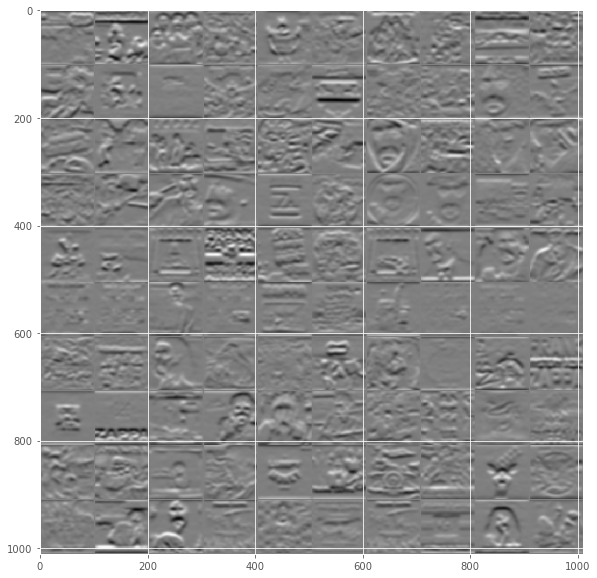

In [8]:
convolved_show = (convolved - np.min(convolved)) / (np.max(convolved) - np.min(convolved))
print(convolved_show.shape)
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(convolved_show[..., 0], 'imgs/convolved.png'), cmap='gray')

### Organizing the dataset

We can now attempt to group the images by sorting the mean value of each convolved image's output. All we need to do is find the mean value for each image and return a list of sorted img indices to build a new array `sorted_imgs`

In [9]:
# get sorted idxs
idxs_op = images.sort_convolved_idx_op(convolved)
idxs = sess.run(idxs_op)

# use sorted indices to sort your images:
sorted_imgs = np.array([imgs[idx_i] for idx_i in idxs])

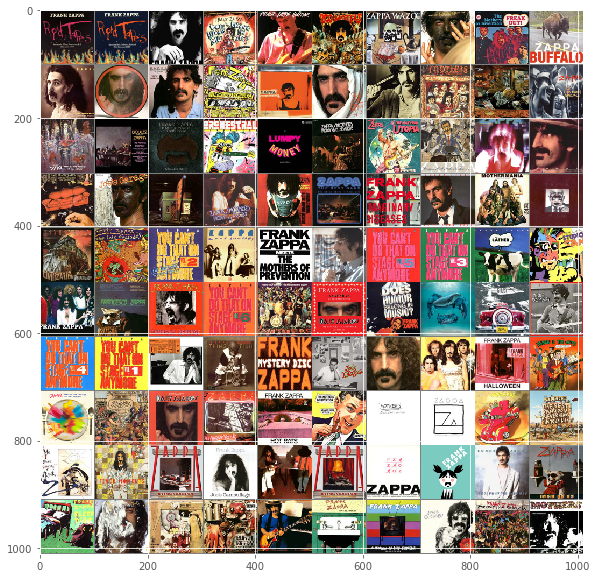

In [10]:
# view sorted imgs
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(sorted_imgs, 'sorted.png'))

## Painting Images

Now that we have sorted all of the album covers based on the edges detected using the Gabor kernel, we can now feed these images into a neural network and attempt to paint each of the album covers.

We will build the the model first:

In [11]:
def build_model(xs, ys, n_neurons, n_layers, activation_fn,
                final_activation_fn, cost_type):
    
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    
    if xs.ndim != 2:
        raise ValueError(
            'xs should be a n_observates x n_features, ' +
            'or a 2-dimensional array.')
    if ys.ndim != 2:
        raise ValueError(
            'ys should be a n_observates x n_features, ' +
            'or a 2-dimensional array.')
        
    n_xs = xs.shape[1]
    n_ys = ys.shape[1]
    
    X = tf.placeholder(name='X', shape=[None, n_xs],
                       dtype=tf.float32)
    Y = tf.placeholder(name='Y', shape=[None, n_ys],
                       dtype=tf.float32)

    current_input = X
    for layer_i in range(n_layers):
        current_input = utils.linear(
            current_input, n_neurons,
            activation=activation_fn,
            name='layer{}'.format(layer_i))[0]

    Y_pred = utils.linear(
        current_input, n_ys,
        activation=final_activation_fn,
        name='pred')[0]
    
    if cost_type == 'l1_norm':
        cost = tf.reduce_mean(tf.reduce_sum(
                tf.abs(Y - Y_pred), 1))
    elif cost_type == 'l2_norm':
        cost = tf.reduce_mean(tf.reduce_sum(
                tf.squared_difference(Y, Y_pred), 1))
    else:
        raise ValueError(
            'Unknown cost_type: {}.  '.format(
            cost_type) + 'Use only "l1_norm" or "l2_norm"')
    
    return {'X': X, 'Y': Y, 'Y_pred': Y_pred, 'cost': cost}

Now let's write a training method that will help us collect all of the points of every image and try to predict the output colors of those pixels. The network will receive the row and column, and also an number for which image it is in the d. This should help the network to better distinguish the patterns it uses, as it has knowledge that helps it separates its process based on which image is fed as input.

We will teach the network to go from the location on each image frame to a particular color. So for any position in any image, the network will need to learn what color to paint. We can do this by aggregating each of the pixel locations and their colors (which is done in `images.split_image`)

In [12]:
def train(imgs,
          learning_rate=0.0001,
          batch_size=200,
          n_iterations=10,
          gif_step=2,
          n_neurons=30,
          n_layers=10,
          activation_fn=tf.nn.relu,
          final_activation_fn=tf.nn.tanh,
          cost_type='l2_norm'):

    N, H, W, C = imgs.shape
    all_xs, all_ys = [], []
    for img_i, img in enumerate(imgs):
        xs, ys = images.split_image(img)
        all_xs.append(np.c_[xs, np.repeat(img_i, [xs.shape[0]])])
        all_ys.append(ys)
    xs = np.array(all_xs).reshape(-1, 3)
    xs = (xs - np.mean(xs, 0)) / np.std(xs, 0)
    ys = np.array(all_ys).reshape(-1, 3)
    ys = ys / 127.5 - 1

    g = tf.Graph()
    with tf.Session(graph=g) as sess:
        model = build_model(xs, ys, n_neurons, n_layers,
                            activation_fn, final_activation_fn,
                            cost_type)
        optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(model['cost'])
        sess.run(tf.global_variables_initializer())
        gifs = []
        costs = []
        step_i = 0
        for it_i in range(n_iterations):
            # Get a random sampling of the dataset
            idxs = np.random.permutation(range(len(xs)))

            # The number of batches we have to iterate over
            n_batches = len(idxs) // batch_size
            training_cost = 0

            # Iterate over minibatches:
            for batch_i in range(n_batches):

                # Get just minibatch amount of data
                idxs_i = idxs[batch_i * batch_size:
                              (batch_i + 1) * batch_size]

                # And optimize, also returning the cost so we can monitor
                # how our optimization is doing.
                cost = sess.run(
                    [model['cost'], optimizer],
                    feed_dict={model['X']: xs[idxs_i],
                               model['Y']: ys[idxs_i]})[0]
                training_cost += cost

            print('iteration {}/{}: cost {}'.format(
                    it_i + 1, n_iterations, training_cost / n_batches))

            # every gif_step iterations, draw prediction of
            # input xs, which should look like it's recreating image
            if (it_i + 1) % gif_step == 0:
                costs.append(training_cost / n_batches)
                ys_pred = model['Y_pred'].eval(
                    feed_dict={model['X']: xs}, session=sess)
                img = ys_pred.reshape(imgs.shape)
                gifs.append(img)
        return gifs

Now we will try training our model to paint all the images using various parameters and see what happens.
Each time we train our network, we will create a gif of the training process over time.

In [13]:
# gifs = train(imgs=sorted_imgs,
#           n_iterations=10,
#           batch_size=10,
#           n_neurons=64,
#           n_layers=23)

# final = gifs[-1]
# final_gif = [np.clip(((m * 127.5) + 127.5), 0, 255) for m in final]
# gif.build_gif(final_gif, saveto='gifs/final-10-10-64.gif')

ipyd.Image(url='gifs/final-10-10-64.gif?{}'.format(np.random.rand()),
           height=200, width=200)

In [14]:
# gifs = train(imgs=sorted_imgs,
#           n_iterations=64,
#           batch_size=23,
#           n_neurons=64,
#           n_layers=23)

# final = gifs[-1]
# final_gif = [np.clip(((m * 127.5) + 127.5), 0, 255) for m in final]
# gif.build_gif(final_gif, saveto='gifs/final-10-10-64.gif')

ipyd.Image(url='gifs/final-64-23-64-23.gif?{}'.format(np.random.rand()),
           height=200, width=200)

In [15]:
# gifs = train(imgs=sorted_imgs,
#           batch_size=200,
#           n_iterations=50,
#           n_neurons=64,
#           n_layers=23)

# final = gifs[-1]
# final_gif = [np.clip(((m * 127.5) + 127.5), 0, 255) for m in final]
# gif.build_gif(final_gif, saveto='gifs/final-200-50-64-23.gif')

ipyd.Image(url='gifs/final-200-50-64-23.gif?{}'.format(np.random.rand()),
           height=200, width=200)

In [16]:
# gifs = train(imgs=sorted_imgs,
#           n_iterations=100,
#           n_neurons=64,
#           n_layers=23)

# final = gifs[-1]
# final_gif = [np.clip(((m * 127.5) + 127.5), 0, 255) for m in final]
# gif.build_gif(final_gif, saveto='gifs/final.gif')

ipyd.Image(url='gifs/final.gif?{}'.format(np.random.rand()),
           height=200, width=200)

Now we'll create a gif out of the training process:

In [17]:
# montage_gifs = [np.clip(utils.montage(
#             (m * 127.5) + 127.5), 0, 255).astype(np.uint8)
#                 for m in gifs]
# _ = gif.build_gif(montage_gifs, saveto='multiple.gif')

ipyd.Image(url='gifs/multiple.gif?{}'.format(np.random.rand()),
           height=500, width=500)

What we're seeing is the training process over time.  We feed in our `xs`, which consist of the pixel values of each of our 100 images, it goes through the neural network, and out come predicted color values for every possible input value.  We visualize it above as a gif by seeing how at each iteration the network has predicted the entire space of the inputs.  We can visualize just the last iteration as a "latent" space, going from the first image (the top left image in the montage), to the last image, (the bottom right image).

### Favorite Album cover paintings

Some of these turned out fairly good, here are some of my favorites

In [18]:
ipyd.Image(url='gifs/apostrophe.gif?{}'.format(np.random.rand()),
           height=200, width=200)

In [19]:
ipyd.Image(url='gifs/bw.gif?{}'.format(np.random.rand()),
           height=200, width=200)

In [20]:
ipyd.Image(url='gifs/weasels.gif?{}'.format(np.random.rand()),
           height=200, width=200)

In [21]:
ipyd.Image(url='gifs/woiiftm.gif?{}'.format(np.random.rand()),
           height=200, width=200)

## Summary

Overall this was a very interesting exploration. I attempted to do "image inpainting" using 100 of Frank Zappa's album covers and feeding the images to a neural network which would predict the expected color values for each pixel in each image. I created gifs of the training process over time.

I used these gifs in a music video for "Screeches & Regalia" by Idol Eyes, which is a cover of Frank Zappa's Peaches & Regalia off the album Hot Rats. https://vimeo.com/225358961

Overall, I would like to have been able to create higher-quality images. I used a Macbook Air which only had 4 GB RAM and no GPU, which is not extremely well-suited for any sort of deeper networks or more hi-res images.